# La costruzione, l'addestramento, e il funzionamento di una semplice rete neurale per leggere cifre scritte a mano
Luca Mari, novembre 2024

Quest'opera è distribuita con <a href="http://creativecommons.org/licenses/by-nc-sa/4.0" target="_blank">Licenza Creative Commons Attribuzione - Non commerciale - Condividi allo stesso modo 4.0 Internazionale</a>.  
<img src="https://creativecommons.it/chapterIT/wp-content/uploads/2021/01/by-nc-sa.eu_.png" width="100">

**Obiettivo**: comprendere la struttura di una semplice rete neurale, il suo addestramento e il suo funzionamento, per come specificati in Python mediante un modulo di alto livello come `PyTorch`.    
**Precompetenze**: eventuali basi di Python (il codice Python è ovunque semplice, perché richiama funzioni che nascondono molti dettagli, salvo che in alcuni punti in cui i dettagli stessi sono considerati di particolare interesse).

<a href="#s1">1. Il problema</a>  
<a href="#s2">2. Il dataset</a>  
<a href="#s3">3. La costruzione della rete</a>  
<a href="#s4">4. L'addestramento della rete</a>  
<a href="#s5">5. Il funzionamento della rete</a>

> Per eseguire questo notebook, supponiamo con VSCode, occorre:
> * installare un interprete Python
> * scaricare da https://code.visualstudio.com/download e installare VSCode
> * eseguire VSCode e attivare le estensioni per Python e Jupyter
> * ancora in VSCode:
>    * creare una cartella di lavoro e renderla la cartella corrente
>    * copiare nella cartella i file di questa attività: [mnist.ipynb](mnist.ipynb) e [mnistutils.py](mnistutils.py)
>     * aprire il notebook `mnist.ipynb`
>    * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
>    * installare i moduli Python richiesti, eseguendo dal terminale:  
>        `pip install torch torchvision numpy matplotlib`

# <a name="s1"></a>
### 1. Il problema

Vogliamo costruire una rete neurale che sappia riconoscere cifre scritte a mano. A questo scopo, sia per addestrare la rete sia poi per metterla alla prova useremo [il dataset MNIST](https://en.wikipedia.org/wiki/MNIST_database), che contiene appunto immagini di cifre scritte a mano, e per ognuna l'informazione di quale cifra è scritta.  
Si tratta perciò di un problema di classificazione: per ogni immagine che le è sottoposta, la rete deve trovare a quale delle 10 classi appartiene: 0, 1, ..., 9.

Ogni immagine nel dataset è digitalizzata in una matrice di 28x28 = 784 punti e ogni punto ha un colore nella scala dei grigi, codificato in 8 bit, cioè 1 byte; ogni immagine corrisponde a una delle possibili 10 cifre: 0, 1, ..., 9.  
Dunque la rete ha il compito di accettare in _input_ un vettore di circa 1000 numeri tra 0 e 255 e di produrre in _output_ un numero tra 0 e 9.

# <a name="s2"></a>
### 2. Il dataset

Dopo aver importato i moduli Python necessari, recuperiamo dal web il dataset, distinguendo tra _training set_ e _test set_.  
Il primo ci servirà per addestrare la rete, il secondo per metterla alla prova, ovviamente con immagini diverse da quelle con cui era stata addestrata per assicurarci che se la rete sarà capace di riconoscere correttamente le immagini non è perché ha memorizzato quanto le è stato mostrato durante l'addestramento.

In [4]:
from mnistutils import load_data, show_images, train_loop, test_loop, test_with_prob, test_loop_with_trace

train_data, test_data = load_data()

print(f'Il training set contiene {len(train_data)} immagini')
print(f'e il test set contiene {len(test_data)} immagini.')

Il training set contiene 60000 immagini
e il test set contiene 10000 immagini.


Ora che il dataset è disponibile, possiamo mostrare qualche esempio delle immagini che contengono le cifre che vogliamo addestrare la rete a riconoscere, insieme con l'indicazione della cifre corretta, informazione anch'essa contenuta nei file che abbiamo scaricato.

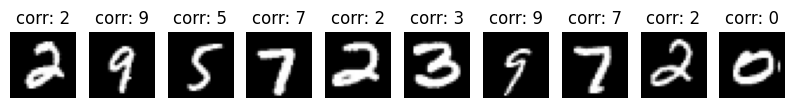

In [5]:
show_images(train_data)

La varietà e l'irregolarità della scrittura a mano in queste immagini suggeriscono che ideare un algoritmo per risolvere il nostro problema di classificazione e poi implementarlo in un programma potrebbe essere estremamente complesso, come infatti confermano i limitati risultati ottenuti dai sistemi software sviluppati in accordo a questa strategia.

<a name="s3"></a>
### 3. La costruzione della rete

Cerchiamo dunque invece di risolvere il problema con la logica del _machine learning_, costruendo e poi addestrando una rete neurale. Lo faremo partendo da una rete con una struttura molto semplice (un _MultiLayer Perceptron_, MLP), organizzata in "strati" (_layer_):
* lo _strato di input_ realizza un "occhio artificiale" con 28x28 punti sensibili, tanti quanti punti ha ogni immagine da classificare; ogni volta che viene sottoposta un'immagine alla rete, ognuno di questi punti sensibili assume il valore corrispondente al colore di un punto dell'immagine;
* lo _strato di output_ contiene 10 neuroni, uno per ogni possibile classe in cui classificare un'immagine, e quindi uno per ogni possibile cifra riconoscibile; ogni volta che viene sottoposta un'immagine alla rete e la rete viene fatta funzionare, ognuno di questi neuroni dovrà assumere come valore la probabilità che l'immagine contenga la cifra corrispondente, e quindi complessivamente i valori dei 10 neuroni sono una distribuzione di probabilità sull'insieme 0, 1, ..., 9;
* tra lo strato di input e quello di output introduciamo un "cervello" realizzato con _strati interni_ (in inglese: _hidden layer_): manterremo questo esempio assai semplice, con un solo strato interno con soli 10 neuroni.

La parte davvero importante di questa rete sono le sue "sinapsi", cioè le connessioni tra i neuroni, perché sono esse a essere adattabili, in quanto parametri della funzione realizzata dalla rete stessa. È grazie a esse che durante l'addestramento la rete può modificare il suo comportamento e imparare a classificare le immagini.  
In questa rete ogni neurone di uno strato è collegato a ogni neurone dello strato successivo, e quindi con qualche moltiplicazione è facile calcolare quanti parametri ha la rete.

Questa è dunque la struttura della rete:  

![rete](mnist_simple.drawio.svg)

In accordo a queste indicazioni costruiamo finalmente la rete.

In [13]:
import torch
from torch import nn

class MLP_NN(nn.Module):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(   # Sequential() costruisce una successione di componenti
            nn.Linear(28*28, 10),       # Linear(x, y) costruisce la connessione tra tutti gli x neuroni di uno strato e gli y neuroni dello strato successivo
            nn.ReLU(),                  # ReLU() stabilisce che la funzione di attivazione per il segnale in uscita dai neuroni sia ReLu (rectified linear unit)
            nn.Linear(10, 10)
        )

    def forward(self, x):
        x = nn.Flatten()(x)             # Flatten() rende unidimensionale l'input, adattando così le immagini allo strato di input
        return self.network(x)

network = MLP_NN()

num_MLP_params = sum(p.numel() for p in network.parameters())
print(f"Abbiamo costruito una rete con {num_MLP_params} parametri.")

Abbiamo costruito una rete con 7960 parametri.


Già ora possiamo far funzionare la rete, ancora prima di averla addestrata e quindi con i suoi parametri inizializzati a valori casuali. Per ogni immagine scelta a caso, la rete produce una distribuzione di probabilità, e da questa scegliamo come cifra prevista ("prev") quella più probabile nella distribuzione. Ma la distribuzione che otteniamo è praticamente uniforme, cioè è in condizioni "di minima informazione" (e quindi di massima ignoranza / entropia): come ci potevamo aspettare, senza addestramento la rete non è in grado di fare nulla di utile.

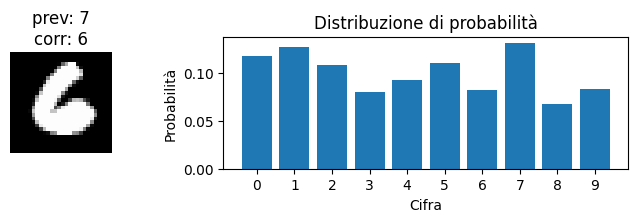

In [10]:
test_with_prob(test_data, network)

<a name="s4"></a>
### 4. L'addestramento della rete

È dunque il momento di progettare l'addestramento della rete, e per questo dobbiamo prima di tutto decidere "il programma scolastico": gli iperparametri dell'addestramento e le funzioni per la _backpropagation_.

In [14]:
learning_rate = 1e-3                    # velocità di apprendimento
batch_size = 100                        # numero di immagini per gruppo
num_batches = 500                       # numero di gruppi di immagini per epoca
epochs = 30                             # numero di epoche

loss_fn = nn.CrossEntropyLoss()         # funzione per calcolare gli errori
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate) # funzione per correggere gli errori

A questo punto possiamo finalmente "mandare a scuola" la rete. E alla fine di ogni "giorno di scuola" la sottoponiamo a una prova, per valutare se sta imparando a classificare correttamente le immagini.

In [15]:
import time

print("Epoca\tAccuratezza")
correct = test_loop(test_data, batch_size, network) / batch_size * 100
print(f"0\t{correct:.0f}%")

start_time = time.time()
accuracy = []
for t in range(epochs):
    train_loop(train_data, batch_size, num_batches, network, loss_fn, optimizer)
    correct = test_loop(test_data, batch_size, network) / batch_size * 100
    print(f"{t + 1}\t{correct:.0f}%")
    accuracy.append(correct)
end_time = time.time()

print(f"Addestramento completato in {end_time - start_time:.0f} secondi")

Epoca	Accuratezza
0	8%
1	9%
2	27%
3	39%
4	44%
5	58%
6	58%
7	67%
8	74%
9	76%
10	81%
11	79%
12	75%
13	84%
14	82%
15	77%
16	85%
17	84%
18	78%
19	82%
20	83%
21	80%
22	88%
23	81%
24	91%
25	91%
26	87%
27	85%
28	82%
29	89%
30	87%
Addestramento completato in 79 secondi


Visualizzando in un grafico i valori di accuratezza durante l'addestramento vediamo che il processo non è deterministico...

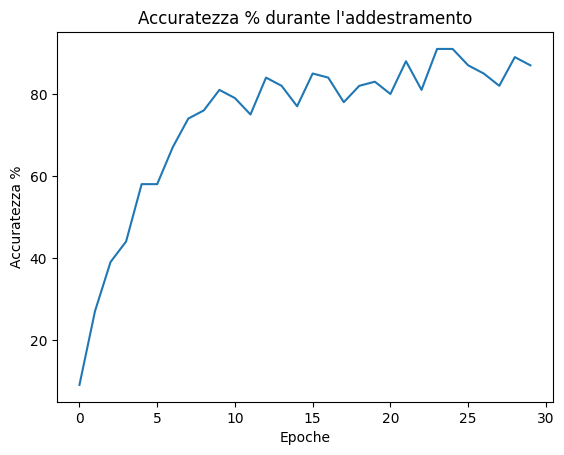

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), accuracy)
plt.xlabel('Epoche')
plt.ylabel('Accuratezza %')
plt.title("Accuratezza % durante l'addestramento")
plt.show()

<a name="s5"></a>
### 5. Il funzionamento della rete

Ora che la rete è addestrata, la possiamo far funzionare, e valutare l'accuratezza delle sue classificazioni, ovviamente sempre in riferimento a immagini del _test set_, su cui non era stata addestrata.

In [21]:
batch_size = 1000
correct = test_loop(test_data, batch_size, network) / batch_size * 100
print(f"Accuratezza: {correct:.1f}%")

Accuratezza: 84.5%


Possiamo anche valutare qualitativamente il comportamento della rete confrontando la cifra prevista e quella corretta per 10 immagini prese a caso dal _test set_.

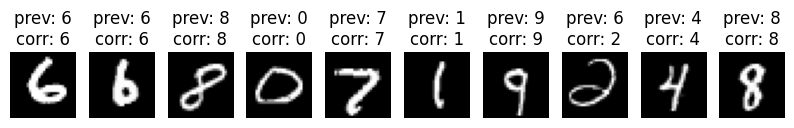

In [25]:
test_loop_with_trace(test_data, network)

E possiamo infine visualizzare la distribuzione di probabilità prodotta come risultato dell'elaborazione di una singola immagine. È qui evidente l'effetto dell'addestramento: anche se la struttura della rete non è cambiata, e dunque non abbiamo modificato la rete riprogrammandola, la distribuzione non è più uniforme, ma ha generalmente una o poche categorie a probabilità elevata. Insomma, questa significativa differenza di comportamento è interamente dovuta all'addestramento a cui abbiamo sottoposto la rete.

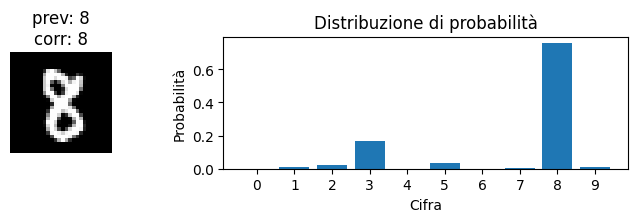

In [26]:
test_with_prob(test_data, network)